# SVD for Plane Fitting

In this example, we will use Singular Value Decomposition to fit a plane to a noisy 3D point cloud. 

In [1]:
# Import the required modules

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import transforms3d as tf3d


In [2]:
# Enable interactive 3D plots in Jupyter.

%matplotlib notebook

First, we define some utility functions:

In [3]:
def quat_from_to(v1: np.ndarray, v2: np.ndarray):
    """Get a quaternion rotating vector v1 to v2 in [w x y z] format."""
    quat = np.array([1., 0., 0., 0.])
    quat[1:] = np.cross(v1, v2)
    quat[0] = np.sqrt((np.linalg.norm(v1) ** 2) * (np.linalg.norm(v2) ** 2)) + np.dot(v1, v2)
    return quat



def transform_point(tf_mat4x4: np.ndarray, vector_3):
    """Transform a 3D position by a 4x4 affine transformation matrix."""
    return (tf_mat4x4 @ np.concatenate([vector_3, [1]]))[:3]



def get_plane_tf_mat(normal: np.ndarray, offset: np.ndarray) -> np.ndarray:
    """Get the transformation from XY plane coordinates to 3D XYZ coordinates."""
    translation = offset * normal

    rot_quat = quat_from_to([0., 0., 1.], normal)
    rot_mat = tf3d.quaternions.quat2mat(rot_quat)

    tf_mat = tf3d.affines.compose(R=rot_mat, T=translation, Z=np.ones(3))
    return tf_mat



def plot_plane(ax: Axes3D, normal, offset, size=10, alpha=0.5, color=None):
    """Plot a plane as quad in 3D."""
    points = np.array([[[size, size, 0], [-size, size, 0]],
                       [[size, -size, 0], [-size, -size, 0]]])

    tf_mat = get_plane_tf_mat(normal, offset)
    points_tf = np.apply_along_axis(lambda x: transform_point(tf_mat, x), axis=-1, arr=points)

    return ax.plot_surface(*points_tf.T, alpha=alpha, color=color)

Then, we prepare the example:

In [4]:
# Define ground truth plane.
plane_normal_gt = np.array([1, 2, 3])
plane_normal_gt = plane_normal_gt / np.linalg.norm(plane_normal_gt)
plane_offset_gt = 2

print("Ground truth plane:")
print(f"- normal: {plane_normal_gt}")
print(f"- offset: {plane_offset_gt}")
print("")

tf_mat_gt = get_plane_tf_mat(plane_normal_gt, plane_offset_gt)
print(f"Ground truth transformation matrix:\n{tf_mat_gt}")

Ground truth plane:
- normal: [0.26726124 0.53452248 0.80178373]
- offset: 2

Ground truth transformation matrix:
[[ 0.96035675 -0.07928651  0.26726124  0.53452248]
 [-0.07928651  0.84142698  0.53452248  1.06904497]
 [-0.26726124 -0.53452248  0.80178373  1.60356745]
 [ 0.          0.          0.          1.        ]]


Preparing 3D plot


<IPython.core.display.Javascript object>


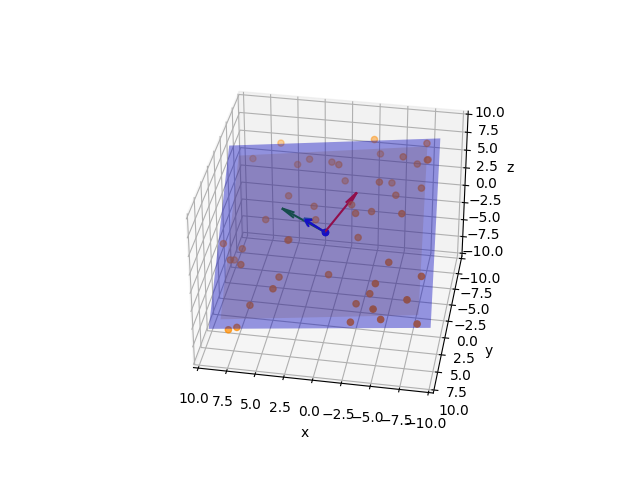

In [5]:
# Prepare the 3D plot.
print("Preparing 3D plot")
fig: plt.Figure = plt.figure()
ax: Axes3D = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

fig.show()

In [6]:
do_vis_ground_truth = True
if do_vis_ground_truth:
    # Visualize ground truth plane.
    print("Visualizing ground truth plane")
    plane_origin_gt = transform_point(tf_mat_gt, [0, 0, 0])

    plot_plane(ax, plane_normal_gt, plane_offset_gt, size=9, alpha=0.2, color="orange")
    ax.scatter(*plane_origin_gt)
    ax.quiver(*plane_origin_gt, *plane_normal_gt, length=5)

Visualizing ground truth plane


In [7]:
# Generate data
noise_mean = 0.0
noise_std = 1.0
num = 50
print("Generating data (noise: {:.2f}+-{:.2f}, num: {})".format(noise_mean, noise_std, num))

# Generate uniform X, Y (positions on plane) and Gaussian Z data (noise)
data_plane = np.stack([np.random.uniform(-10, 10, size=num) for i in range(2)]
                      + [np.random.normal(noise_mean, scale=noise_std, size=num)])
data = np.apply_along_axis(lambda x: transform_point(tf_mat_gt, x), axis=0, arr=data_plane)
print("- Generated data matrix: {}".format(data.shape))  # (3, num)

Generating data (noise: 0.00+-1.00, num: 50)
- Generated data matrix: (3, 50)


In [8]:
do_vis_data = True
if do_vis_data:
    ax.scatter(*data, color="darkorange")

Now, we perform the plane estimation:

In [9]:
# Estimate plane
print("Estimating plane")

# Find centroid and subtract from data
print("- Computing centroid")
centroid_est = np.mean(data, axis=1)
data_zero_mean = (data.T - centroid_est).T

# Perform SVD to find normal
print("- Performing SVD")
u, s, vh = np.linalg.svd(data_zero_mean, full_matrices=True, compute_uv=True)
# Best normal is left singular vector of least singular value.
plane_x_est, plane_y_est, plane_normal_est = u[:, 0], u[:, 1], u[:, 2]
plane_offset_est = np.dot(centroid_est, plane_normal_est)

print("Estimated plane:")
print("- normal:", plane_normal_est)
print("- offset:", plane_offset_est)

Estimating plane
- Computing centroid
- Performing SVD
Estimated plane:
- normal: [0.24197112 0.56158722 0.79124571]
- offset: 1.9417089375495538


In [10]:
do_vis_estimated = True
if do_vis_estimated:
    print("Visualizing estimated plane")
    tf_mat_est = get_plane_tf_mat(plane_normal_gt, plane_offset_gt)
    plane_origin_est = transform_point(tf_mat_est, [0, 0, 0])

    plot_plane(ax, normal=plane_normal_est, offset=plane_offset_est, color="blue", alpha=0.4)
    ax.scatter(*plane_origin_est, color="blue")
    ax.quiver(*plane_origin_est, *plane_normal_est, length=5, color="blue")

    ax.quiver(*plane_origin_est, *plane_x_est, length=5, color="red")
    ax.quiver(*plane_origin_est, *plane_y_est, length=5, color="green")

Visualizing estimated plane
